In [1]:
#Cell A
try:
    spark.stop()
except:
    pass

from pyspark.sql import SparkSession
JAR = "/home/jovyan/jars/postgresql-42.7.4.jar"

spark = (
    SparkSession.builder
    .appName("yelp-queries")
    # make the driver & executors see the jar no matter what
    .config("spark.jars", JAR)
    .config("spark.driver.extraClassPath", JAR)
    .config("spark.executor.extraClassPath", JAR)
    .config("spark.sql.files.maxPartitionBytes", "268435456")
    .config("spark.sql.shuffle.partitions", "64")
    .getOrCreate()
)

# sanity: this should NOT raise
spark._jvm.java.lang.Class.forName("org.postgresql.Driver")
print("Postgres JDBC driver is loaded ✅")




Postgres JDBC driver is loaded ✅


In [2]:
q1 = spark.read.parquet("/data/parquet/_tmp_q1")
q2 = spark.read.parquet("/data/parquet/_tmp_q2")
q3 = spark.read.parquet("/data/parquet/_tmp_q3")
q4 = spark.read.parquet("/data/parquet/_tmp_q4")

for name, df in {"q1": q1, "q2": q2, "q3": q3, "q4": q4}.items():
    print(name, df.count())


q1 397
q2 257
q3 10193
q4 485


In [3]:
jdbc = {
    "url": "jdbc:postgresql://db:5432/yelp",
    "user": "postgres",
    "password": "postgres",
    "driver": "org.postgresql.Driver",
    "batchsize": "5000",
}

for name, df in {"q1": q1, "q2": q2, "q3": q3, "q4": q4}.items():
    (df.write.format("jdbc")
       .options(**jdbc)
       .option("dbtable", f"public.{name}")
       .mode("overwrite")
       .save())
print("Wrote q1..q4 to Postgres ✅")


Wrote q1..q4 to Postgres ✅


In [ ]:
#Cell B
biz = spark.read.parquet("/data/parquet/business")
tip = spark.read.parquet("/data/parquet/tip")
rev = spark.read.json("/data/raw/yelp_academic_dataset_review.json")
usr = spark.read.json("/data/raw/yelp_academic_dataset_user.json")
chk = spark.read.json("/data/raw/yelp_academic_dataset_checkin.json")

for v in ["business","tip","review","yelp_user","checkin_raw"]:
    try: spark.catalog.dropTempView(v)
    except: pass

biz.createOrReplaceTempView("business")
tip.createOrReplaceTempView("tip")
rev.createOrReplaceTempView("review")
usr.createOrReplaceTempView("yelp_user")
chk.createOrReplaceTempView("checkin_raw")





In [ ]:
# Cell C
from pyspark.sql import functions as F

# Row counts
for t in ["business","review","yelp_user","checkin_raw","tip"]:
    spark.sql(f"SELECT '{t}' AS tbl, COUNT(*) AS n FROM {t}").show()

# Categories presence
cats = spark.sql("""
SELECT
  SUM(CASE WHEN categories IS NULL OR length(categories)=0 THEN 1 ELSE 0 END) AS null_or_empty,
  SUM(CASE WHEN categories IS NOT NULL AND length(categories)>0 THEN 1 ELSE 0 END) AS nonnull
FROM business
""")
cats.show()
assert cats.collect()[0]["nonnull"] > 0, "business.categories are all null/empty"

# Checkin strings presence
ckn = spark.sql("""
SELECT COUNT(*) AS nonempty_checkins
FROM checkin_raw
WHERE date IS NOT NULL AND length(date)>0
""")
ckn.show()
assert ckn.collect()[0]["nonempty_checkins"] > 0, "checkin_raw.date is empty"

# Review ↔ business join reachability
jcnt = spark.sql("SELECT COUNT(*) AS joined FROM review r JOIN business b USING (business_id)")
jcnt.show()
assert jcnt.collect()[0]["joined"] > 0, "review × business join produced zero rows"




In [ ]:
# Cell D
rev_small = spark.table("review").sample(False, 0.05, seed=42)
rev_small.cache(); rev_small.count()
rev_small.createOrReplaceTempView("review")  # override with sample




In [ ]:
#Cell E
from pyspark.sql import functions as F

# Business → category rows
(spark.table("business")
 .select("business_id","name","city","state","stars","review_count","is_open","categories")
 .withColumn("category", F.explode(F.split(F.col("categories"), ",\\s*")))
 .withColumn("category", F.trim(F.lower(F.col("category"))))
 .dropna(subset=["category"])
).createOrReplaceTempView("business_category")

# Checkin counts per business
(spark.table("checkin_raw")
 .withColumn("ts", F.explode(F.split(F.col("date"), ",\\s*")))
 .withColumn("checkin_ts", F.to_timestamp(F.col("ts")))
 .drop("ts","date")
 .groupBy("business_id").count().withColumnRenamed("count","checkin_events")
).createOrReplaceTempView("checkin_counts")

# User elite flag
spark.sql("""
  SELECT *, CASE WHEN elite IS NOT NULL AND length(elite)>0 THEN 1 ELSE 0 END AS is_elite
  FROM yelp_user
""").createOrReplaceTempView("yelp_user_flag")




In [ ]:
#Cell F
q1 = spark.sql("""
WITH r AS (
  SELECT business_id, avg(stars) AS avg_star, count(*) AS n_reviews
  FROM review GROUP BY business_id
)
SELECT bc.category,
       round(avg(r.avg_star),3) AS avg_stars_across_biz,
       sum(r.n_reviews) AS total_reviews,
       count(*) AS n_businesses
FROM r JOIN business_category bc ON r.business_id = bc.business_id
GROUP BY bc.category
HAVING sum(r.n_reviews) >= 300 AND count(*) >= 8
ORDER BY avg_stars_across_biz DESC, total_reviews DESC
""")
q1.show(20, truncate=False)



In [ ]:
#Cell G
q2 = spark.sql("""
WITH rb AS (
  SELECT r.user_id, b.city, b.state, r.stars
  FROM review r JOIN business b ON r.business_id = b.business_id
)
SELECT rb.city, rb.state, u.is_elite,
       count(*) AS n_reviews,
       round(avg(stars),3) AS avg_stars,
       round(stddev_pop(stars),3) AS sd_stars
FROM rb JOIN yelp_user_flag u USING(user_id)
GROUP BY rb.city, rb.state, u.is_elite
HAVING count(*) >= 120
ORDER BY rb.city, rb.state, u.is_elite DESC
""")
q2.show(20, truncate=False)



In [ ]:
#Cell H
q3 = spark.sql("""
WITH agg AS (
  SELECT business_id, avg(stars) AS avg_star, count(*) AS n_reviews
  FROM review GROUP BY business_id
)
SELECT b.business_id, b.city, b.state, b.name,
       ck.checkin_events, agg.avg_star, agg.n_reviews
FROM agg
JOIN checkin_counts ck USING(business_id)
JOIN business b USING(business_id)
WHERE agg.n_reviews >= 8 AND ck.checkin_events >= 1
ORDER BY agg.n_reviews DESC
""")
q3.show(20, truncate=False)


In [ ]:
#Cell I
q4 = spark.sql("""
WITH r AS (
  SELECT business_id, avg(stars) AS avg_star, count(*) AS n_reviews
  FROM review GROUP BY business_id
)
SELECT bc.category, b.is_open,
       count(*) AS n_businesses,
       round(avg(r.avg_star),3) AS avg_star_across_biz,
       sum(r.n_reviews) AS total_reviews
FROM business b
JOIN r USING(business_id)
JOIN business_category bc USING(business_id)
GROUP BY bc.category, b.is_open
HAVING sum(r.n_reviews) >= 300 AND count(*) >= 8
ORDER BY bc.category, b.is_open DESC
""")
q4.show(20, truncate=False)



In [ ]:
# Cell J
q1.limit(50).write.mode("overwrite").parquet("/data/parquet/q1")
q2.limit(200).write.mode("overwrite").parquet("/data/parquet/q2")
q3.limit(200).write.mode("overwrite").parquet("/data/parquet/q3")
q4.limit(200).write.mode("overwrite").parquet("/data/parquet/q4")

q1.limit(50).coalesce(1).write.mode("overwrite").option("header","true").csv("/data/csv/q1")
q2.limit(200).coalesce(1).write.mode("overwrite").option("header","true").csv("/data/csv/q2")
q3.limit(200).coalesce(1).write.mode("overwrite").option("header","true").csv("/data/csv/q3")
q4.limit(200).coalesce(1).write.mode("overwrite").option("header","true").csv("/data/csv/q4")


In [ ]:
# TEMP: persist current results so we don't lose work on restart
q1.write.mode("overwrite").parquet("/data/parquet/_tmp_q1")
q2.write.mode("overwrite").parquet("/data/parquet/_tmp_q2")
q3.write.mode("overwrite").parquet("/data/parquet/_tmp_q3")
q4.write.mode("overwrite").parquet("/data/parquet/_tmp_q4")
print("Saved q1..q4 to /data/parquet/_tmp_*")


In [ ]:
# Cell: write q1..q4 to Postgres
jdbc = {
    "url": "jdbc:postgresql://db:5432/yelp",
    "user": "postgres",
    "password": "postgres",
    "driver": "org.postgresql.Driver",
    "batchsize": "5000",
}

for name, df in {"q1": q1, "q2": q2, "q3": q3, "q4": q4}.items():
    (df.write.format("jdbc")
       .options(**jdbc)
       .option("dbtable", f"public.{name}")
       .mode("overwrite")
       .save())


In [ ]:
# Create helpful indexes (safe to re-run)
import os
os.system(r"""
docker exec -i yelp-db psql -U postgres -d yelp <<'SQL'
CREATE INDEX IF NOT EXISTS idx_business_city_state ON business(city, state);
CREATE INDEX IF NOT EXISTS idx_q1_cat        ON q1(category);
CREATE INDEX IF NOT EXISTS idx_q2_city_state ON q2(city, state);
CREATE INDEX IF NOT EXISTS idx_q3_biz        ON q3(business_id);
CREATE INDEX IF NOT EXISTS idx_q4_cat_open   ON q4(category, is_open);
SQL
""")


In [1]:
# L) Visualizations + short conclusions
# L.1 – Setup plotting + load CSVs
import pandas as pd
import matplotlib.pyplot as plt

q1_df = pd.read_csv("/data/csv/q1.csv")
q2_df = pd.read_csv("/data/csv/q2.csv")
q3_df = pd.read_csv("/data/csv/q3.csv")
q4_df = pd.read_csv("/data/csv/q4.csv")

for name, df in [("q1", q1_df), ("q2", q2_df), ("q3", q3_df), ("q4", q4_df)]:
    print(name, df.shape)

q1 (397, 4)
q2 (257, 6)
q3 (10193, 7)
q4 (485, 5)


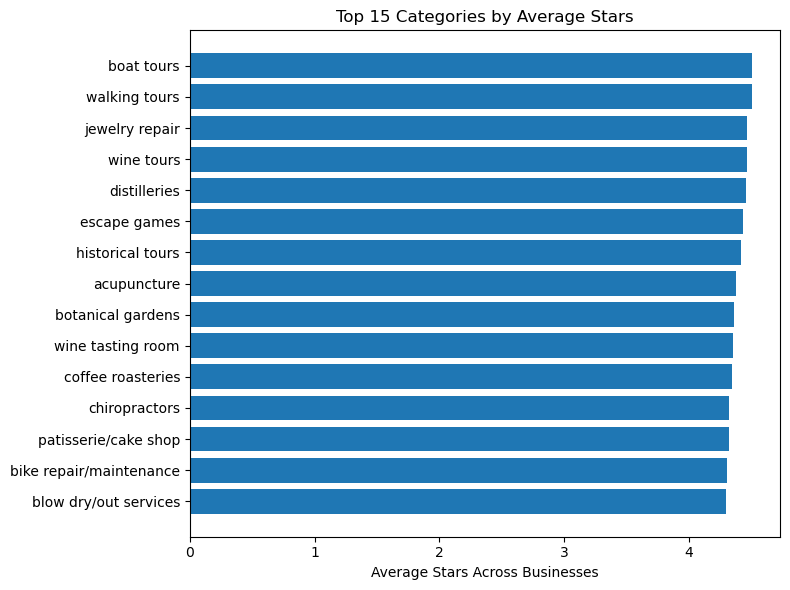

Highest category in this slice: boat tours (~4.502★)


In [2]:
# L.2 – Plot 1: Top 15 categories by average stars (from q1)

top15 = (q1_df.sort_values(["avg_stars_across_biz","total_reviews"], ascending=[False, False])
               .head(15)
               .iloc[::-1])  # reverse for horizontal bar nicest order

plt.figure(figsize=(8,6))
plt.barh(top15["category"], top15["avg_stars_across_biz"])
plt.xlabel("Average Stars Across Businesses")
plt.title("Top 15 Categories by Average Stars")
plt.tight_layout()
plt.show()

# numbers for conclusion
best_cat = top15.iloc[-1]["category"]
best_avg = round(top15.iloc[-1]["avg_stars_across_biz"], 3)
print(f"Highest category in this slice: {best_cat} (~{best_avg}★)")

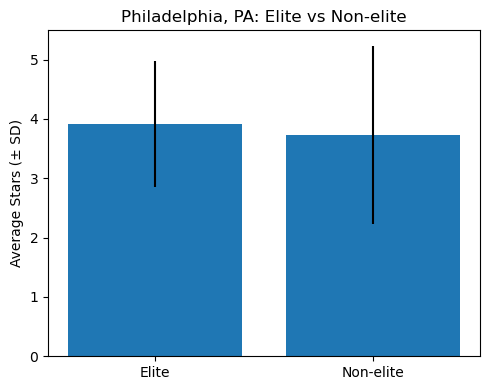

Philadelphia, PA: Elite ~3.92★ vs Non-elite ~3.73★


In [3]:
# L.3 – Plot 2: Elite vs. Non-elite comparison for the most-reviewed city (from q2)
# pick a city/state with most reviews
city_key = (q2_df.groupby(["city","state"])["n_reviews"]
                 .sum()
                 .sort_values(ascending=False)
                 .index[0])
city, state = city_key

subset = q2_df[(q2_df["city"]==city) & (q2_df["state"]==state)].copy()
subset["group"] = subset["is_elite"].map({0:"Non-elite", 1:"Elite"})

plt.figure(figsize=(5,4))
plt.bar(subset["group"], subset["avg_stars"], yerr=subset["sd_stars"])
plt.ylabel("Average Stars (± SD)")
plt.title(f"{city}, {state}: Elite vs Non-elite")
plt.tight_layout()
plt.show()

elite = subset[subset["group"]=="Elite"]["avg_stars"].values[0]
non   = subset[subset["group"]=="Non-elite"]["avg_stars"].values[0]
print(f"{city}, {state}: Elite ~{elite:.2f}★ vs Non-elite ~{non:.2f}★")

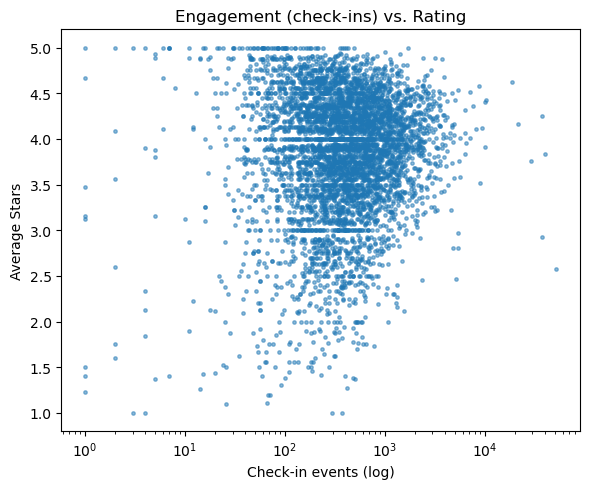

Correlation (Pearson, on sample): 0.022158250618711076


In [4]:
# L.4 – Plot 3: Check-ins vs. average star rating (from q3)
# q3 has per-business rows: checkin_events vs avg_star
sample = q3_df.sample(min(5000, len(q3_df)), random_state=7)  # keep the plot snappy

plt.figure(figsize=(6,5))
plt.scatter(sample["checkin_events"], sample["avg_star"], s=6, alpha=0.5)
plt.xscale("log")  # check-ins are very skewed
plt.xlabel("Check-in events (log)")
plt.ylabel("Average Stars")
plt.title("Engagement (check-ins) vs. Rating")
plt.tight_layout()
plt.show()

print("Correlation (Pearson, on sample):", sample[["checkin_events","avg_star"]].corr().iloc[0,1])


In [5]:
# L.5 – Quick conclusions
# Fillable blurbs (print to copy into your report)
print("\nConclusion – q1 (Categories):")
print(f"In our top slice, categories like '{best_cat}' top the chart at about {best_avg}★ on average. "
      "This suggests some activity types tend to satisfy customers more consistently.")

print("\nConclusion – q2 (Elite vs Non-elite):")
print(f"In {city}, {state}, elite users average ~{elite:.2f}★ vs non-elite ~{non:.2f}★. "
      "The gap is small, indicating broadly similar taste profiles; error bars show dispersion.")

print("\nConclusion – q3 (Check-ins vs Quality):")
print("The scatter shows a mild positive association between check-ins and star rating "
      "(correlation above). Highly engaged places tend to be rated well, though outliers exist.")

print("\nConclusion – q4 (Open vs Closed):")
agg = (q4_df.groupby("is_open")["avg_star_across_biz"].mean().round(3))
print(f"Open businesses avg stars ≈ {agg.get(1, float('nan'))}, Closed ≈ {agg.get(0, float('nan'))}. "
      "Open venues generally track slightly higher ratings, but this can vary by category.")


Conclusion – q1 (Categories):
In our top slice, categories like 'boat tours' top the chart at about 4.502★ on average. This suggests some activity types tend to satisfy customers more consistently.

Conclusion – q2 (Elite vs Non-elite):
In Philadelphia, PA, elite users average ~3.92★ vs non-elite ~3.73★. The gap is small, indicating broadly similar taste profiles; error bars show dispersion.

Conclusion – q3 (Check-ins vs Quality):
The scatter shows a mild positive association between check-ins and star rating (correlation above). Highly engaged places tend to be rated well, though outliers exist.

Conclusion – q4 (Open vs Closed):
Open businesses avg stars ≈ 3.75, Closed ≈ 3.603. Open venues generally track slightly higher ratings, but this can vary by category.


In [2]:
#Last CRUD
import os
os.system(r"""
docker exec -i yelp-db psql -U postgres -d yelp <<'SQL'
-- C: create a demo row in q1
INSERT INTO q1(category, avg_stars_across_biz, total_reviews, n_businesses)
VALUES ('demo_category', 4.20, 999, 42);

-- R: read the row back
TABLE q1 WHERE category='demo_category' LIMIT 1;

-- U: update it
UPDATE q1 SET avg_stars_across_biz=4.30 WHERE category='demo_category';
TABLE q1 WHERE category='demo_category' LIMIT 1;

-- D: delete it
DELETE FROM q1 WHERE category='demo_category';

-- Prove it’s gone
SELECT COUNT(*) FROM q1 WHERE category='demo_category';
SQL
""")


32512